In [ ]:
import pandas as pd
!pip install catboost
import catboost as cat_
import numpy as np
from tqdm import tqdm
import copy
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os
import warnings
import numpy as np  
import seaborn as sns
import pandas as pd, os, gc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline
warnings.filterwarnings('ignore')
from typing import List

In [ ]:
#Importing data
train=pd.read_csv('/content/drive/My Drive/Train (1).csv')
test=pd.read_csv('/content/drive/My Drive/Test (1).csv')

In [ ]:
true_values = []
for v in test.values:
  binary = v[8:]
  index = [k for k, i in enumerate(binary) if i == 1]
  for k in test.columns[8:][index]:
    true_values.append(v[0] + ' X ' + k)

In [ ]:
#Store Products ID in Multidimensional array
products =train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
products_t =test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

#Axis Transformation
train = train.melt(id_vars=train.columns[:8], value_vars=products, var_name = "PCODE", value_name="Label" )
test = test.melt(id_vars=test.columns[:8], value_vars=products, var_name = "PCODE", value_name="Label" )

#A merger
train['combiner']='x'

#Set
data=pd.concat([train,test],sort=False).reset_index(drop=True)

train=data[data.combiner.notnull()].reset_index(drop=True);test=data[data.combiner.isna()].reset_index(drop=True)
train.drop('combiner', inplace=True, axis=1);test.drop(['Label','combiner'], inplace=True, axis=1)

#Concatenate new column towards submission requirement
train['ID X PCODE'] = train['ID'] + ' X ' + train['PCODE'];test['ID X PCODE'] = test['ID'] + ' X ' + test['PCODE']

#Re-arrange column (not necessary)
train=train[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE',  'Label']]
test=test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code',
       'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE']]

In [ ]:
train['date1'] = train['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
train['date2'] = train['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
train['date3'] = train['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
train.drop('join_date', axis=1, inplace=True)

test['date1'] = test['join_date'].apply(lambda x: int(x.split('/')[0]) if (x == x) else np.nan)
test['date2'] = test['join_date'].apply(lambda x: int(x.split('/')[1]) if (x == x) else np.nan)
test['date3'] = test['join_date'].apply(lambda x: int(x.split('/')[2]) if (x == x) else np.nan)
test.drop('join_date', axis=1, inplace=True)

train['date_diff'] = train['date3'] - train['birth_year']
test['date_diff'] = test['date3'] - test['birth_year']

In [ ]:
train

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label,date1,date2,date3,date_diff
0,4WKQSBB,F,M,1987,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0,1.0,2.0,2019.0,32.0
1,CP5S02H,F,M,1981,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0,1.0,6.0,2019.0,38.0
2,2YKDILJ,M,U,1991,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0,1.0,6.0,2013.0,22.0
3,2S9E81J,M,M,1990,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0,1.0,8.0,2019.0,29.0
4,BHDYVFT,M,M,1990,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0,1.0,8.0,2019.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611767,8SBA93U,F,M,1974,748L,2A7I,T4MS,ECY3,8SBA93U X ECY3,0,1.0,9.0,2019.0,45.0
611768,Y73ETTO,M,M,1987,XX25,Q6J6,90QI,ECY3,Y73ETTO X ECY3,0,1.0,11.0,2018.0,31.0
611769,MVXG2LC,M,M,1985,BOAS,6PE7,T4MS,ECY3,MVXG2LC X ECY3,0,1.0,2.0,2019.0,34.0
611770,BUQ8DQN,M,M,1989,UAOD,2A7I,T4MS,ECY3,BUQ8DQN X ECY3,0,1.0,7.0,2019.0,30.0


In [ ]:
test

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,date1,date2,date3,date_diff
0,F86J5PC,M,M,1984,94KC,DZRV,90QI,P5DA,F86J5PC X P5DA,1.0,12.0,2018.0,34.0
1,H6141K3,M,M,1996,1X1H,J9SY,90QI,P5DA,H6141K3 X P5DA,1.0,10.0,2019.0,23.0
2,RBAYUXZ,F,W,1968,UAOD,2A7I,T4MS,P5DA,RBAYUXZ X P5DA,1.0,1.0,2020.0,52.0
3,KCBILBQ,M,M,1989,94KC,2A7I,T4MS,P5DA,KCBILBQ X P5DA,1.0,2.0,2019.0,30.0
4,LSEC1ZJ,F,M,1982,UAOD,0KID,T4MS,P5DA,LSEC1ZJ X P5DA,1.0,2.0,2020.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0GMU5UH,F,M,1986,748L,2A7I,T4MS,ECY3,0GMU5UH X ECY3,1.0,4.0,2019.0,33.0
209996,I9W11CD,M,M,1980,UAOD,0KID,T4MS,ECY3,I9W11CD X ECY3,1.0,8.0,2019.0,39.0
209997,42WTEGT,M,M,1993,748L,SST3,56SI,ECY3,42WTEGT X ECY3,1.0,4.0,2018.0,25.0
209998,8EKC4O9,F,U,1981,49BM,2A7I,T4MS,ECY3,8EKC4O9 X ECY3,1.0,5.0,2015.0,34.0


In [ ]:
numericals=['date1','date2','date3','date_diff','birth_year']

In [ ]:
# perform a robust scaler transform of the dataset
trans = RobustScaler()
train[numericals] = trans.fit_transform(train[numericals])

In [ ]:
X1=train.drop(columns=['ID', 'Label', 'ID X PCODE'],axis=1)

In [ ]:
X1

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,date1,date2,date3,date_diff
0,F,M,0.500000,1X1H,2A7I,T4MS,P5DA,0.0,-0.8,0.5,-0.428571
1,F,M,0.071429,UAOD,2A7I,T4MS,P5DA,0.0,0.0,0.5,0.000000
2,M,U,0.785714,748L,QZYX,90QI,P5DA,0.0,0.0,-2.5,-1.142857
3,M,M,0.714286,1X1H,BP09,56SI,P5DA,0.0,0.4,0.5,-0.642857
4,M,M,0.714286,748L,NO3L,T4MS,P5DA,0.0,0.4,0.5,-0.642857
...,...,...,...,...,...,...,...,...,...,...,...
611767,F,M,-0.428571,748L,2A7I,T4MS,ECY3,0.0,0.6,0.5,0.500000
611768,M,M,0.500000,XX25,Q6J6,90QI,ECY3,0.0,1.0,0.0,-0.500000
611769,M,M,0.357143,BOAS,6PE7,T4MS,ECY3,0.0,-0.8,0.5,-0.285714
611770,M,M,0.642857,UAOD,2A7I,T4MS,ECY3,0.0,0.2,0.5,-0.571429


In [ ]:
# perform a robust scaler transform of the dataset
trans = RobustScaler()
test[numericals] = trans.fit_transform(test[numericals])

In [ ]:
X2=test.drop(columns=['ID', 'ID X PCODE'], axis=1)

In [ ]:
yy=train['Label']

In [ ]:
catFeatureslist=train[['occupation_category_code','occupation_code','branch_code','marital_status','sex','PCODE']]
catFeatureslist1=test[['occupation_category_code','occupation_code','branch_code','marital_status','sex','PCODE']]

In [ ]:
for cf1 in catFeatureslist:
    le = LabelEncoder()
    le.fit(train[cf1].unique())
    train[cf1] = le.transform(train[cf1])

In [ ]:
train

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label,date1,date2,date3,date_diff
0,4WKQSBB,0,1,0.500000,0,17,5,15,4WKQSBB X P5DA,0,0.0,-0.8,0.5,-0.428571
1,CP5S02H,0,1,0.071429,11,17,5,15,CP5S02H X P5DA,0,0.0,0.0,0.5,0.000000
2,2YKDILJ,1,5,0.785714,3,176,1,15,2YKDILJ X P5DA,0,0.0,0.0,-2.5,-1.142857
3,2S9E81J,1,1,0.714286,0,76,0,15,2S9E81J X P5DA,0,0.0,0.4,0.5,-0.642857
4,BHDYVFT,1,1,0.714286,3,148,5,15,BHDYVFT X P5DA,0,0.0,0.4,0.5,-0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611767,8SBA93U,0,1,-0.428571,3,17,5,5,8SBA93U X ECY3,0,0.0,0.6,0.5,0.500000
611768,Y73ETTO,1,1,0.500000,13,170,1,5,Y73ETTO X ECY3,0,0.0,1.0,0.0,-0.500000
611769,MVXG2LC,1,1,0.357143,6,44,5,5,MVXG2LC X ECY3,0,0.0,-0.8,0.5,-0.285714
611770,BUQ8DQN,1,1,0.642857,11,17,5,5,BUQ8DQN X ECY3,0,0.0,0.2,0.5,-0.571429


In [ ]:
for cf1 in catFeatureslist1:
    le = LabelEncoder()
    le.fit(test[cf1].unique())
    test[cf1] = le.transform(test[cf1])

In [ ]:
test

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,date1,date2,date3,date_diff
0,F86J5PC,1,2,0.285714,4,79,1,15,F86J5PC X P5DA,0.0,1.2,0.0,-0.214286
1,H6141K3,1,2,1.142857,0,103,1,15,H6141K3 X P5DA,0.0,0.8,0.5,-1.000000
2,RBAYUXZ,0,7,-0.857143,11,18,5,15,RBAYUXZ X P5DA,0.0,-1.0,1.0,1.071429
3,KCBILBQ,1,2,0.642857,4,18,5,15,KCBILBQ X P5DA,0.0,-0.8,0.5,-0.500000
4,LSEC1ZJ,0,2,0.142857,11,3,5,15,LSEC1ZJ X P5DA,0.0,-0.8,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0GMU5UH,0,2,0.428571,3,18,5,5,0GMU5UH X ECY3,0.0,-0.4,0.5,-0.285714
209996,I9W11CD,1,2,0.000000,11,3,5,5,I9W11CD X ECY3,0.0,0.4,0.5,0.142857
209997,42WTEGT,1,2,0.928571,3,156,0,5,42WTEGT X ECY3,0.0,-0.4,0.0,-0.857143
209998,8EKC4O9,0,6,0.071429,2,18,5,5,8EKC4O9 X ECY3,0.0,-0.2,-1.5,-0.214286


In [ ]:
# retrieve just the numeric input values
num_cols = ['sex',"marital_status","birth_year", 'branch_code','occupation_code', 'occupation_category_code','date1','date2','date3','date_diff','PCODE']

In [ ]:
train.isnull().sum()

ID                           0
sex                          0
marital_status               0
birth_year                   0
branch_code                  0
occupation_code              0
occupation_category_code     0
PCODE                        0
ID X PCODE                   0
Label                        0
date1                       42
date2                       42
date3                       42
date_diff                   42
dtype: int64

In [ ]:
# fill missing values with mean column values
train.fillna(train.mean(), inplace=True)

In [ ]:
test.isnull().sum()

ID                           0
sex                          0
marital_status               0
birth_year                   0
branch_code                  0
occupation_code              0
occupation_category_code     0
PCODE                        0
ID X PCODE                   0
date1                       21
date2                       21
date3                       21
date_diff                   21
dtype: int64

In [ ]:
train.isnull().sum()

ID                          0
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
PCODE                       0
ID X PCODE                  0
Label                       0
date1                       0
date2                       0
date3                       0
date_diff                   0
dtype: int64

In [ ]:
# fill missing values with mean column values
test.fillna(train.mean(), inplace=True)

In [ ]:
test.isnull().sum()

ID                          0
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
PCODE                       0
ID X PCODE                  0
date1                       0
date2                       0
date3                       0
date_diff                   0
dtype: int64

In [ ]:
# perform a robust scaler transform of the dataset
trans = RobustScaler()
train[num_cols] = trans.fit_transform(train[num_cols])

In [ ]:
# perform a robust scaler transform of the dataset
trans = RobustScaler()
test[num_cols] = trans.fit_transform(test[num_cols])

In [ ]:
train

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label,date1,date2,date3,date_diff
0,4WKQSBB,-1.0,0.0,0.500000,-0.571429,-0.081761,0.00,0.5,4WKQSBB X P5DA,0,0.0,-0.8,0.5,-0.428571
1,CP5S02H,-1.0,0.0,0.071429,1.000000,-0.081761,0.00,0.5,CP5S02H X P5DA,0,0.0,0.0,0.5,0.000000
2,2YKDILJ,0.0,4.0,0.785714,-0.142857,0.918239,-1.00,0.5,2YKDILJ X P5DA,0,0.0,0.0,-2.5,-1.142857
3,2S9E81J,0.0,0.0,0.714286,-0.571429,0.289308,-1.25,0.5,2S9E81J X P5DA,0,0.0,0.4,0.5,-0.642857
4,BHDYVFT,0.0,0.0,0.714286,-0.142857,0.742138,0.00,0.5,BHDYVFT X P5DA,0,0.0,0.4,0.5,-0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611767,8SBA93U,-1.0,0.0,-0.428571,-0.142857,-0.081761,0.00,-0.5,8SBA93U X ECY3,0,0.0,0.6,0.5,0.500000
611768,Y73ETTO,0.0,0.0,0.500000,1.285714,0.880503,-1.00,-0.5,Y73ETTO X ECY3,0,0.0,1.0,0.0,-0.500000
611769,MVXG2LC,0.0,0.0,0.357143,0.285714,0.088050,0.00,-0.5,MVXG2LC X ECY3,0,0.0,-0.8,0.5,-0.285714
611770,BUQ8DQN,0.0,0.0,0.642857,1.000000,-0.081761,0.00,-0.5,BUQ8DQN X ECY3,0,0.0,0.2,0.5,-0.571429


In [ ]:
test

,ID,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,date1,date2,date3,date_diff
0,F86J5PC,0.0,0.0,0.285714,0.000,0.408,-1.00,0.5,F86J5PC X P5DA,0.0,1.2,0.0,-0.214286
1,H6141K3,0.0,0.0,1.142857,-0.500,0.600,-1.00,0.5,H6141K3 X P5DA,0.0,0.8,0.5,-1.000000
2,RBAYUXZ,-1.0,5.0,-0.857143,0.875,-0.080,0.00,0.5,RBAYUXZ X P5DA,0.0,-1.0,1.0,1.071429
3,KCBILBQ,0.0,0.0,0.642857,0.000,-0.080,0.00,0.5,KCBILBQ X P5DA,0.0,-0.8,0.5,-0.500000
4,LSEC1ZJ,-1.0,0.0,0.142857,0.875,-0.200,0.00,0.5,LSEC1ZJ X P5DA,0.0,-0.8,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0GMU5UH,-1.0,0.0,0.428571,-0.125,-0.080,0.00,-0.5,0GMU5UH X ECY3,0.0,-0.4,0.5,-0.285714
209996,I9W11CD,0.0,0.0,0.000000,0.875,-0.200,0.00,-0.5,I9W11CD X ECY3,0.0,0.4,0.5,0.142857
209997,42WTEGT,0.0,0.0,0.928571,-0.125,1.024,-1.25,-0.5,42WTEGT X ECY3,0.0,-0.4,0.0,-0.857143
209998,8EKC4O9,-1.0,4.0,0.071429,-0.250,-0.080,0.00,-0.5,8EKC4O9 X ECY3,0.0,-0.2,-1.5,-0.214286


In [ ]:
X=train.drop(columns=['ID', 'Label', 'ID X PCODE'],axis=1)

In [ ]:
y=train['Label']

In [ ]:
X_test1=test.drop(columns=['ID', 'ID X PCODE'], axis=1)

In [ ]:
 from collections import Counter
 from sklearn.datasets import make_classification
 from sklearn.model_selection import train_test_split
 from sklearn.metrics import confusion_matrix
 from imblearn.ensemble import BalancedBaggingClassifier # doctest: +NORMALIZE_WHITESPACE
 '''X, y = make_classification(n_classes=2, class_sep=2,
   weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
   n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
 print('Original dataset shape %s' % Counter(y))'''
#Original dataset shape Counter({1: 900, 0: 100})
'''X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     random_state=0)'''
 bbc = BalancedBaggingClassifier(random_state=42)
 bbc.fit(X, y) # doctest: +ELLIPSIS
BalancedBaggingClassifier(...)
 y_pred = bbc.predict(X_test1)
''' accuracy = accuracy_score(y_test, y_pred)
 print("Accuracy: %.2f%%" % (accuracy * 100.0))
 print(confusion_matrix(y_test, y_pred))'''

' accuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy: %.2f%%" % (accuracy * 100.0))\nprint(confusion_matrix(y_test, y_pred))'

In [ ]:
X_test1

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,PCODE,date1,date2,date3,date_diff
0,0.0,0.0,0.285714,0.000,0.408,-1.00,0.5,0.0,1.2,0.0,-0.214286
1,0.0,0.0,1.142857,-0.500,0.600,-1.00,0.5,0.0,0.8,0.5,-1.000000
2,-1.0,5.0,-0.857143,0.875,-0.080,0.00,0.5,0.0,-1.0,1.0,1.071429
3,0.0,0.0,0.642857,0.000,-0.080,0.00,0.5,0.0,-0.8,0.5,-0.500000
4,-1.0,0.0,0.142857,0.875,-0.200,0.00,0.5,0.0,-0.8,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...
209995,-1.0,0.0,0.428571,-0.125,-0.080,0.00,-0.5,0.0,-0.4,0.5,-0.285714
209996,0.0,0.0,0.000000,0.875,-0.200,0.00,-0.5,0.0,0.4,0.5,0.142857
209997,0.0,0.0,0.928571,-0.125,1.024,-1.25,-0.5,0.0,-0.4,0.0,-0.857143
209998,-1.0,4.0,0.071429,-0.250,-0.080,0.00,-0.5,0.0,-0.2,-1.5,-0.214286


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

================================Fold1====================================
0:	test: 0.7889429	best: 0.7889429 (0)	total: 186ms	remaining: 31m
50:	test: 0.7939331	best: 0.7945667 (46)	total: 8.81s	remaining: 28m 39s
100:	test: 0.8151869	best: 0.8151869 (100)	total: 17.6s	remaining: 28m 47s
150:	test: 0.8130866	best: 0.8164778 (107)	total: 26.4s	remaining: 28m 42s
200:	test: 0.8103182	best: 0.8164778 (107)	total: 35.1s	remaining: 28m 29s
250:	test: 0.8093505	best: 0.8164778 (107)	total: 43.8s	remaining: 28m 19s
300:	test: 0.8107201	best: 0.8164778 (107)	total: 56.2s	remaining: 30m 9s
350:	test: 0.8119664	best: 0.8164778 (107)	total: 1m 4s	remaining: 29m 43s
400:	test: 0.8122633	best: 0.8164778 (107)	total: 1m 13s	remaining: 29m 21s
450:	test: 0.8129986	best: 0.8164778 (107)	total: 1m 22s	remaining: 29m 3s
500:	test: 0.8124698	best: 0.8164778 (107)	total: 1m 31s	remaining: 28m 47s
550:	test: 0.8121429	best: 0.8164778 (107)	total: 1m 39s	remaining: 28m 31s
600:	test: 0.8124158	best: 0.81647

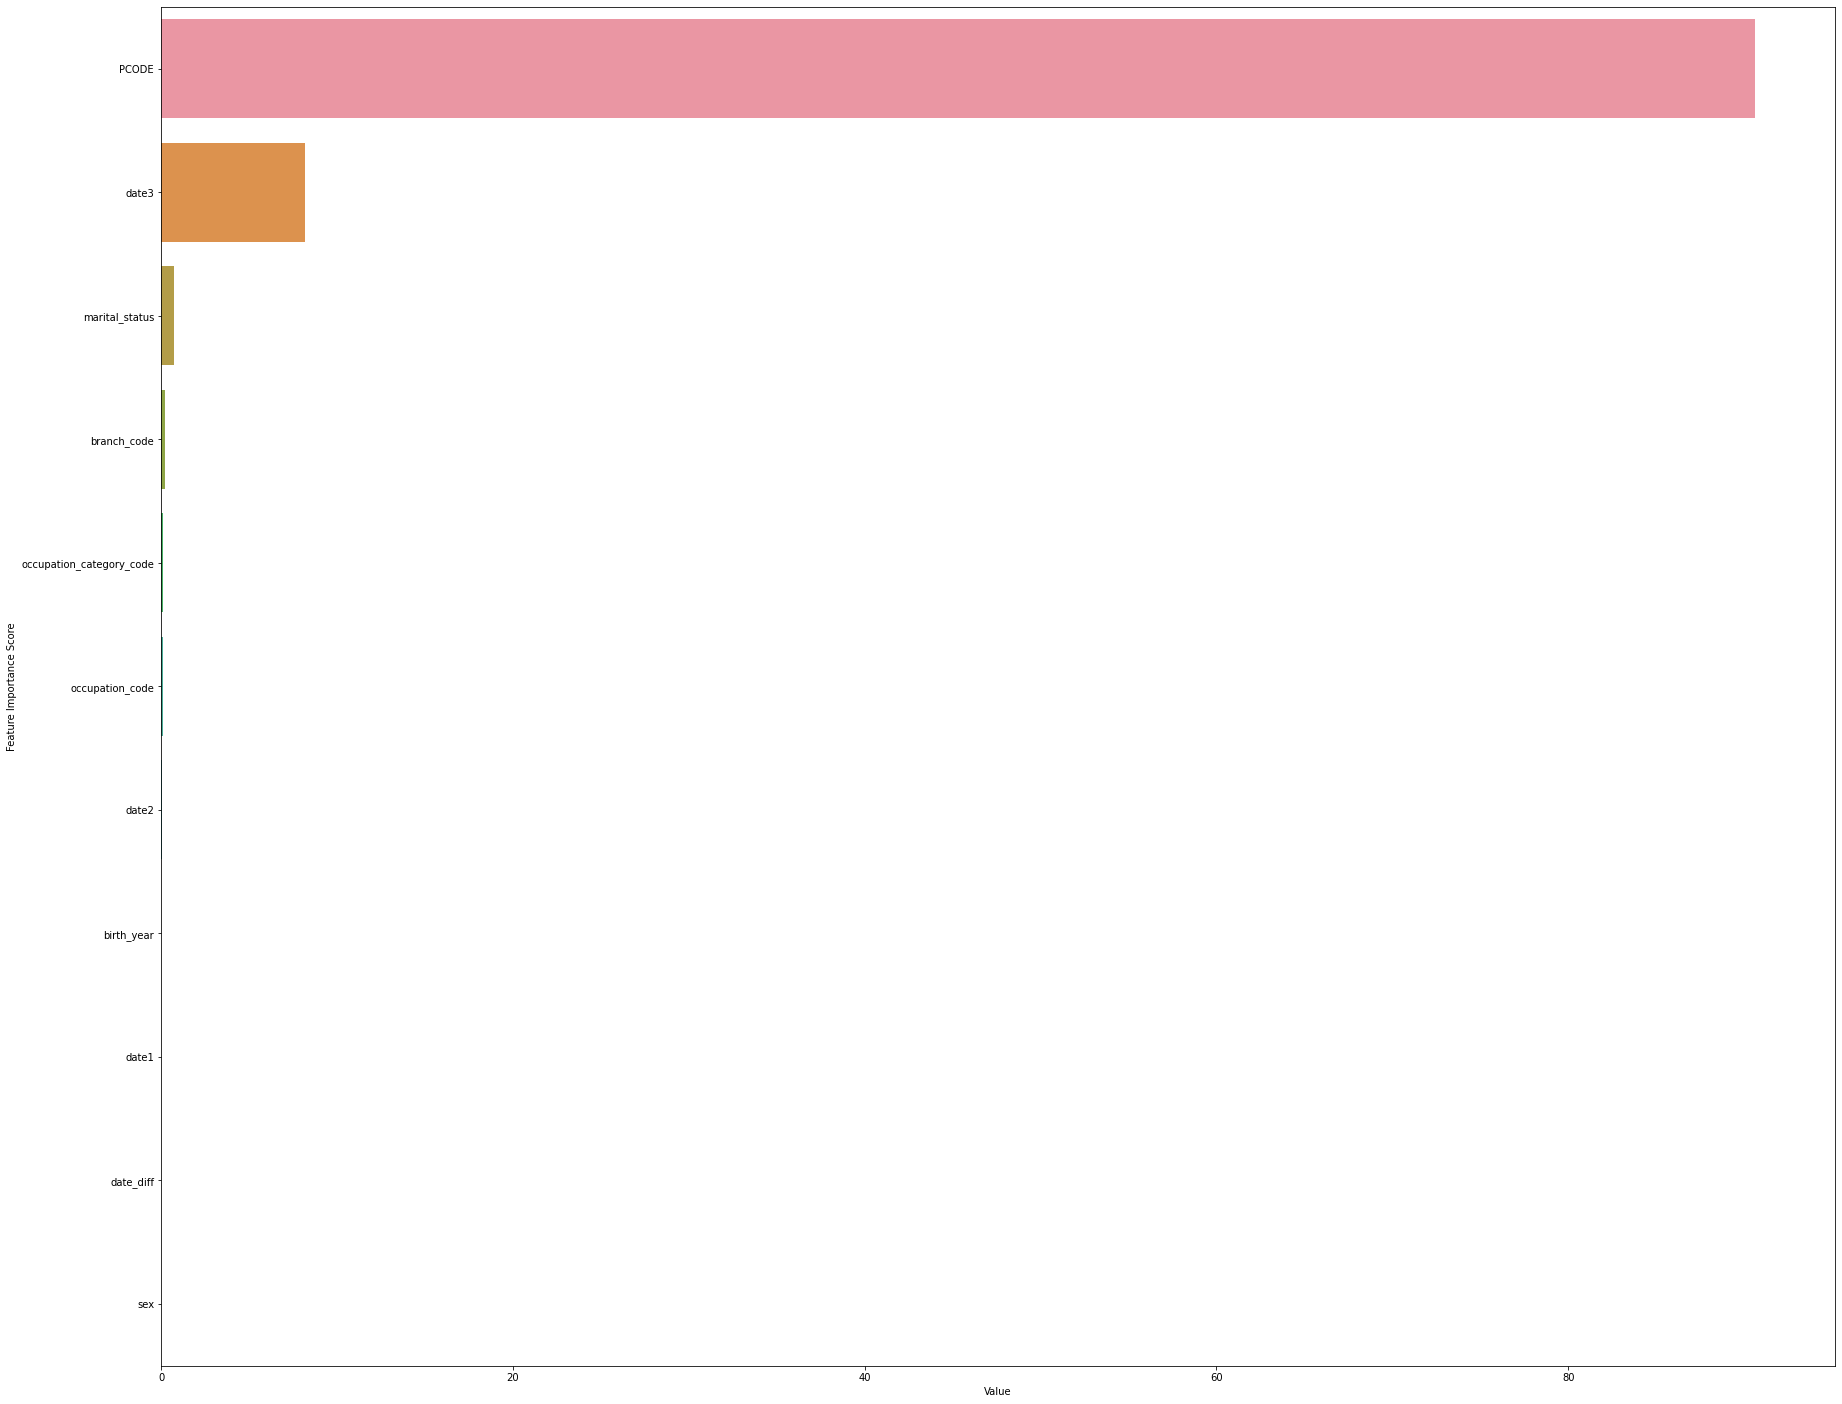

0.8404085263166537 0.9519854179563071 0.04813487284198344


In [ ]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, devices='0:1')

func_= func(X, y, X_test1, catboost, 'catboost', 1000)
val_p, test_p, model1 = func_()

================================Fold1====================================
[0]	validation_0-auc:0.812982
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.806737
[2]	validation_0-auc:0.806737
[3]	validation_0-auc:0.806887
[4]	validation_0-auc:0.806887
[5]	validation_0-auc:0.806887
[6]	validation_0-auc:0.807891
[7]	validation_0-auc:0.807931
[8]	validation_0-auc:0.807931
[9]	validation_0-auc:0.80793
[10]	validation_0-auc:0.80793
[11]	validation_0-auc:0.80793
[12]	validation_0-auc:0.793019
[13]	validation_0-auc:0.793019
[14]	validation_0-auc:0.793011
[15]	validation_0-auc:0.792479
[16]	validation_0-auc:0.792732
[17]	validation_0-auc:0.79361
[18]	validation_0-auc:0.793718
[19]	validation_0-auc:0.793991
[20]	validation_0-auc:0.795088
[21]	validation_0-auc:0.795816
[22]	validation_0-auc:0.796168
[23]	validation_0-auc:0.796103
[24]	validation_0-auc:0.796293
[25]	validation_0-auc:0.795403
[26]	validation_0-auc:0.795536
[27]	validation_0-auc:0.795593
[28]	val

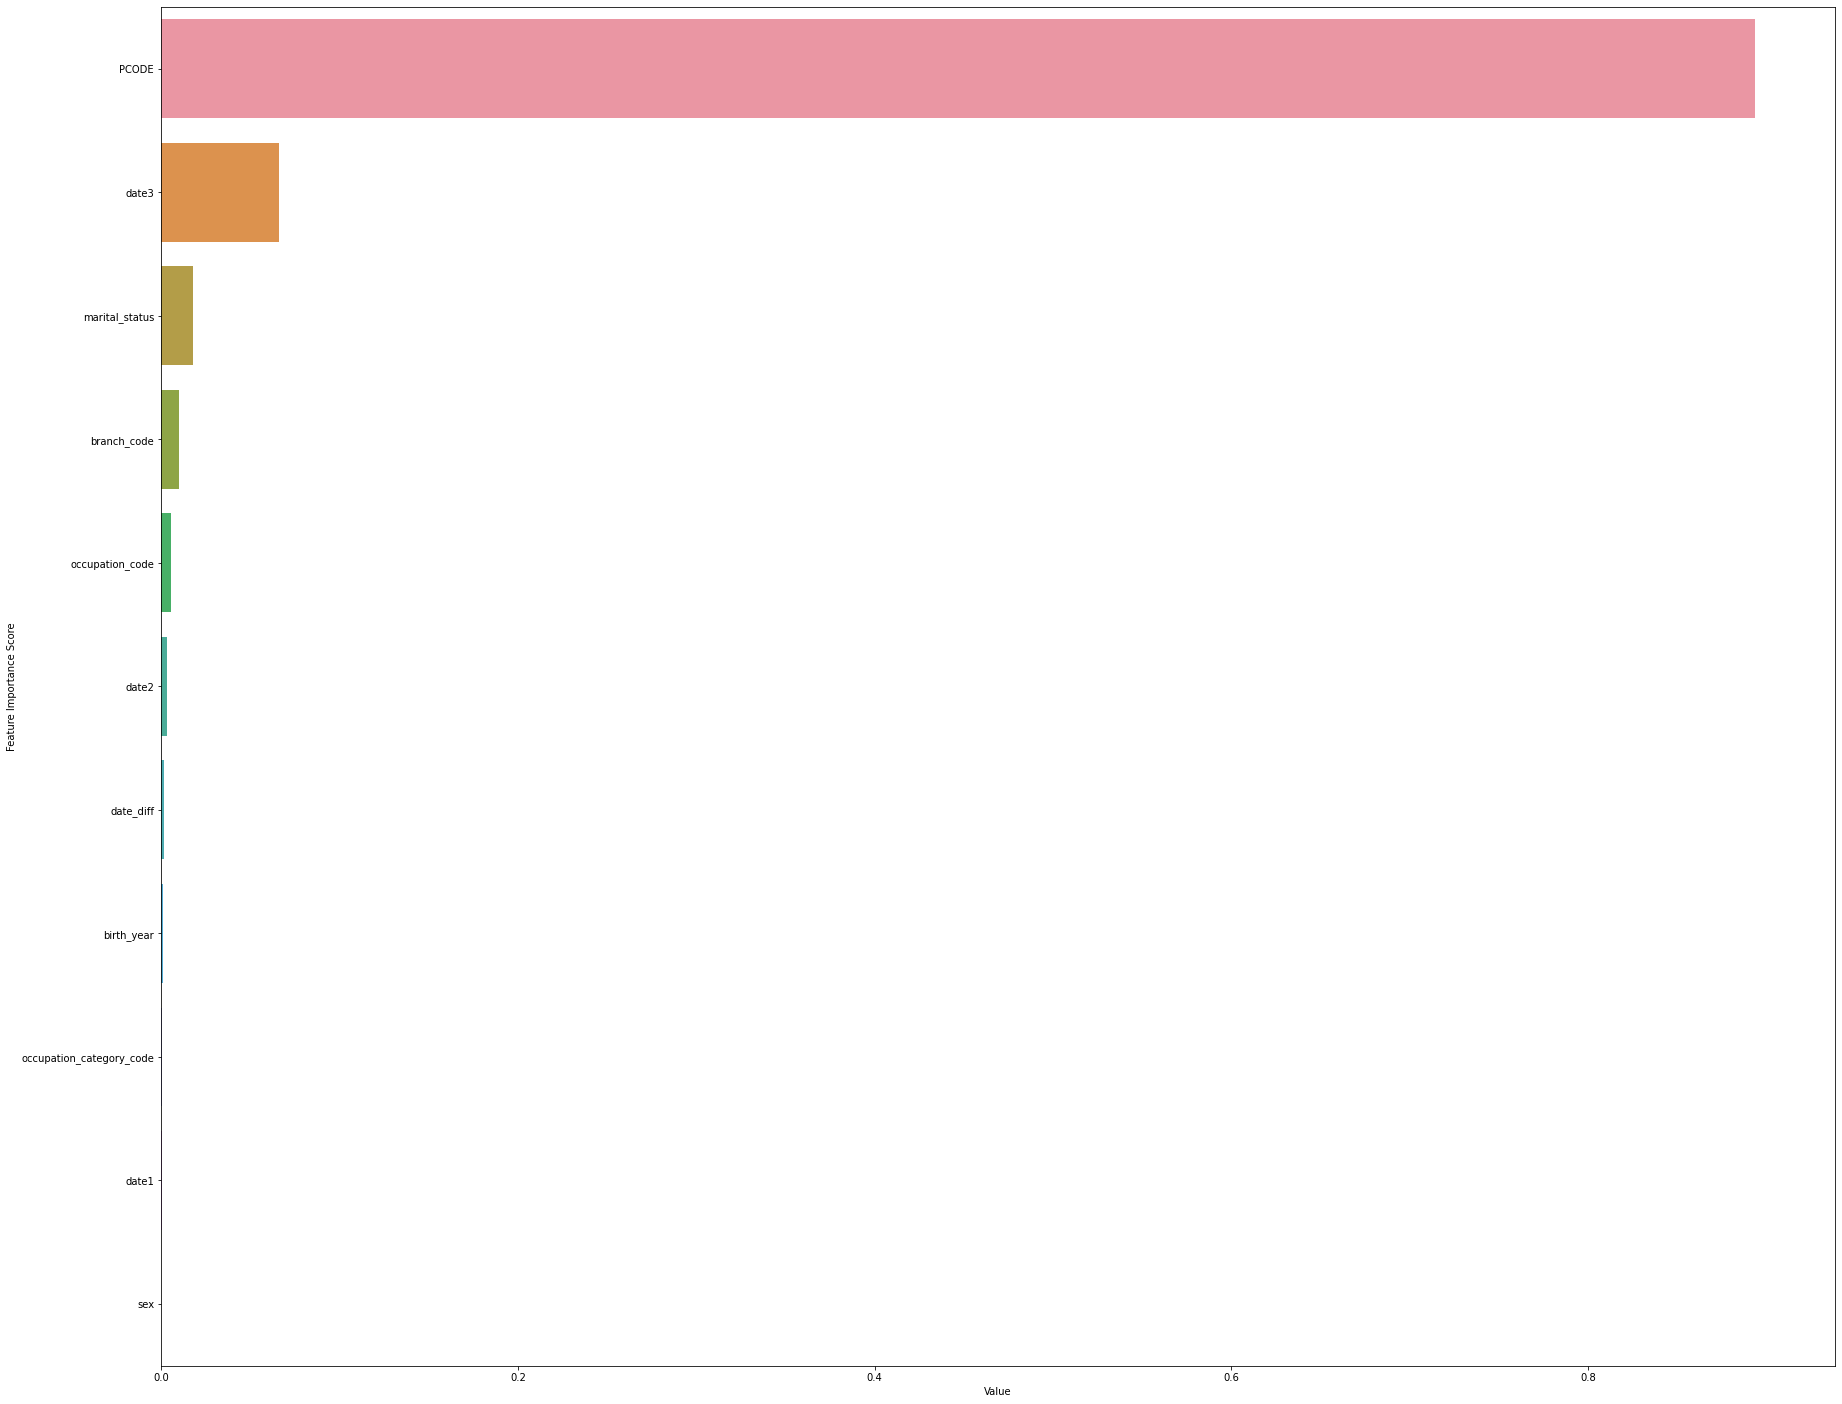

0.8406516655338496 0.913779051539185 0.06780956391550058


In [ ]:
xgboost = XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8)

func_= func(X, y, X_test1, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.90355
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.905958
[3]	valid_0's auc: 0.908245
[4]	valid_0's auc: 0.908234
[5]	valid_0's auc: 0.908459
[6]	valid_0's auc: 0.907898
[7]	valid_0's auc: 0.907827
[8]	valid_0's auc: 0.907626
[9]	valid_0's auc: 0.907345
[10]	valid_0's auc: 0.907346
[11]	valid_0's auc: 0.907858
[12]	valid_0's auc: 0.907956
[13]	valid_0's auc: 0.907908
[14]	valid_0's auc: 0.907128
[15]	valid_0's auc: 0.907023
[16]	valid_0's auc: 0.907074
[17]	valid_0's auc: 0.906675
[18]	valid_0's auc: 0.906481
[19]	valid_0's auc: 0.906367
[20]	valid_0's auc: 0.905903
[21]	valid_0's auc: 0.905729
[22]	valid_0's auc: 0.905542
[23]	valid_0's auc: 0.905497
[24]	valid_0's auc: 0.905466
[25]	valid_0's auc: 0.905316
[26]	valid_0's auc: 0.905156
[27]	valid_0's auc: 0.904787
[28]	valid_0's auc: 0.904728
[29]	valid_0's auc: 0.904782
[30]	valid_0's auc: 0.9045
[31]	v

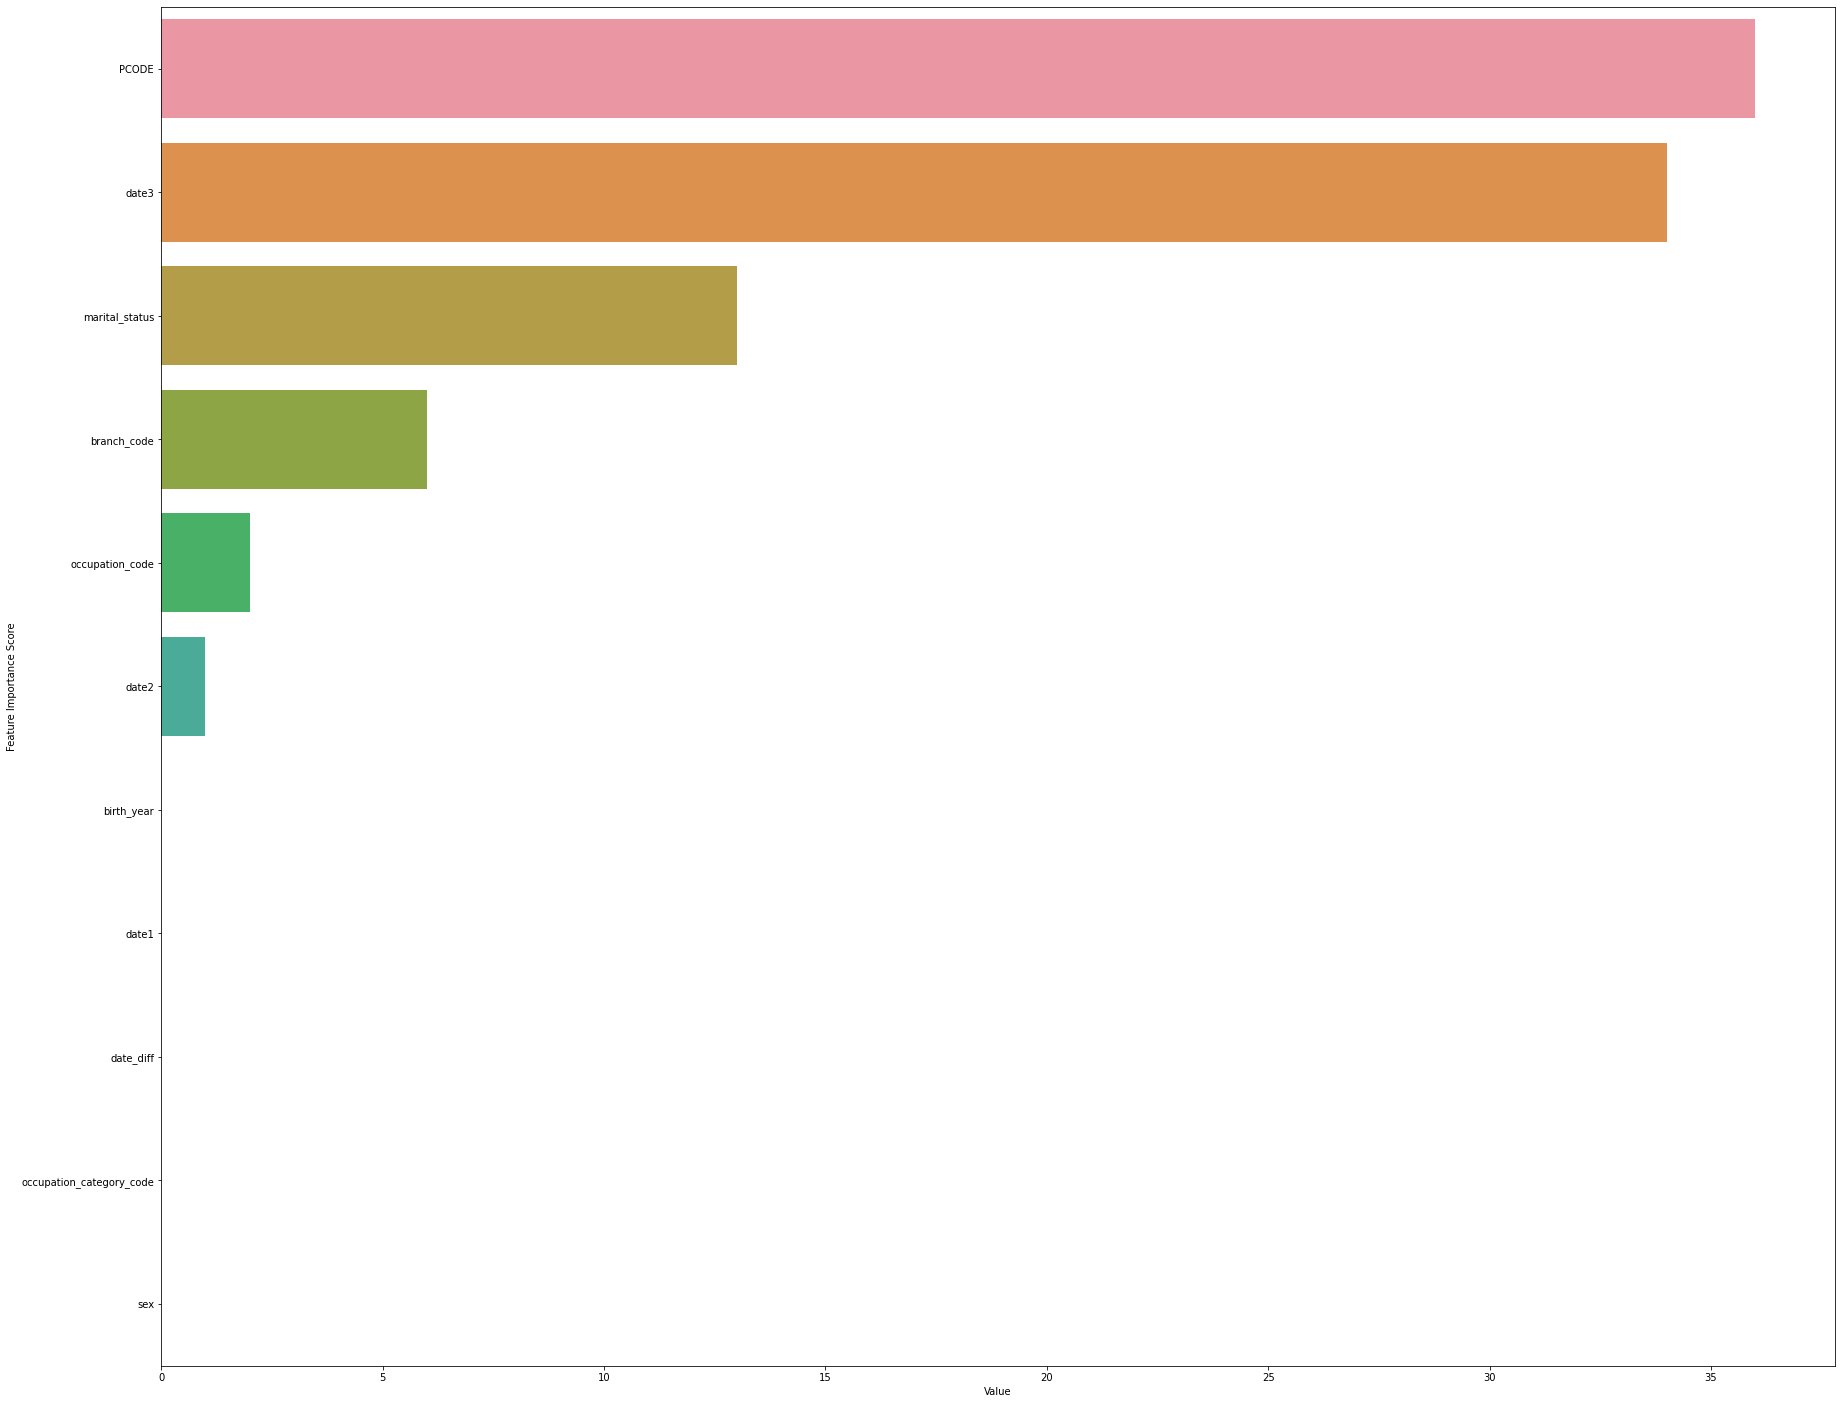

0.8593223638839328 0.9478022963419676 0.07042827822121844


In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(X, y, X_test1, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p, val_p2, val_p3))
stack_p = np.column_stack((test_p, test_p2, test_p3))
predict = RandomForestClassifier().fit(stack, y).predict_proba(stack_p)[:,1]

In [ ]:
predict

In [ ]:
 #bbc.fit(X, y)

In [ ]:
y_pred4=bbc.predict_proba(X_test1)[:,1]

In [ ]:
y_pred4

array([0. , 0. , 0. , ..., 0. , 0.1, 0.3])

In [ ]:
df_answer = test[['ID X PCODE']]
df_answer['Label'] = predict

In [ ]:
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
  if df_answer['ID X PCODE'].iloc[i] in true_values:
    df_answer['Label'].iloc[i] = 1.0

df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('submission8.csv', index=False)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_clf=SVC(gamma='auto',probability=True)
svc_clf.fit(X,y)

In [ ]:
pree=svc_clf.predict.proba(X_test1)[:,1]

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [ ]:
model = lgb.LGBMClassifier()

In [ ]:
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
predict_train = model.predict_proba(X_test1)[:,1]

In [ ]:
predict_train

array([0.00502156, 0.00210075, 0.00578118, ..., 0.00647631, 0.01864925,
       0.02466637])

In [ ]:
df_answer = test[['ID X PCODE']]
df_answer['Label'] = predict_train

In [ ]:
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
  if df_answer['ID X PCODE'].iloc[i] in true_values:
    df_answer['Label'].iloc[i] = 1.0

df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('submission8.csv', index=False)

In [ ]:
!pip install catboost


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X_traincat,X_testcat,y_traincat,y_testcat = train_test_split(X1,yy,test_size = 0.2,random_state=1)

In [ ]:
model_cat1 = CatBoostClassifier()
model_cat1.fit(X_traincat, y_traincat, cat_features=['sex','marital_status','branch_code','occupation_code','occupation_category_code','PCODE'])

In [ ]:
cat_model=CatBoostClassifier()
cat_model.fit(X1,yy,cat_features=['sex','marital_status','branch_code','occupation_code','occupation_category_code','PCODE'])

Learning rate set to 0.159517
0:	learn: 0.4720387	total: 789ms	remaining: 13m 7s
1:	learn: 0.3400401	total: 1.45s	remaining: 12m 2s
2:	learn: 0.2616355	total: 2.02s	remaining: 11m 11s
3:	learn: 0.2182267	total: 2.65s	remaining: 11m
4:	learn: 0.1840738	total: 3.26s	remaining: 10m 49s
5:	learn: 0.1687360	total: 3.94s	remaining: 10m 52s
6:	learn: 0.1572428	total: 4.5s	remaining: 10m 39s
7:	learn: 0.1477295	total: 5.07s	remaining: 10m 28s
8:	learn: 0.1434123	total: 5.63s	remaining: 10m 19s
9:	learn: 0.1378272	total: 6.14s	remaining: 10m 7s
10:	learn: 0.1338390	total: 6.71s	remaining: 10m 3s
11:	learn: 0.1305040	total: 7.29s	remaining: 10m
12:	learn: 0.1284664	total: 8.01s	remaining: 10m 8s
13:	learn: 0.1270367	total: 8.6s	remaining: 10m 5s
14:	learn: 0.1258030	total: 9.16s	remaining: 10m 1s
15:	learn: 0.1248691	total: 9.74s	remaining: 9m 59s
16:	learn: 0.1237787	total: 10.3s	remaining: 9m 56s
17:	learn: 0.1230524	total: 11s	remaining: 10m 1s
18:	learn: 0.1225618	total: 11.7s	remaining: 10m

In [ ]:
proba2= cat_model.predict_proba(X2)[:,1]

In [ ]:
proba2

array([0.00608623, 0.00207381, 0.01043471, ..., 0.00076547, 0.01061234,
       0.0134683 ])

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
log_loss(y_testcat,probaaa)

0.10615043666419244

In [ ]:
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier()
model_cat.fit(X1, yy, cat_features=['sex','marital_status','branch_code','occupation_code','occupation_category_code','PCODE'])

In [ ]:
proba = model_cat.predict_proba(X2)[:,1]

In [ ]:
proba

array([0.00608623, 0.00207381, 0.01043471, ..., 0.00076547, 0.01061234,
       0.0134683 ])

In [ ]:
df_answer = test[['ID X PCODE']]
df_answer['Label'] = proba2

In [ ]:
df_answer.columns = ['ID X PCODE', 'Label']
for i in range(df_answer.shape[0]):
  if df_answer['ID X PCODE'].iloc[i] in true_values:
    df_answer['Label'].iloc[i] = 1.0

df_answer.reset_index(drop=True, inplace=True)
df_answer.to_csv('submission00.csv', index=False)